# Multi-year Maintenance Planning Framework (MMPF)
This notebook provide implementation code of MMPF framework proposed in following paper. 

Allah Bukhsh, Z., Stipanovic, I., & Doree, A. G. (2020). Multi-year maintenance planning framework using multi-attribute utility theory and genetic algorithms. European Transport Research Review, 12(1), 3. https://link.springer.com/article/10.1186/s12544-019-0388-y

The framework is illustrated with a dummy data. 

In [151]:
#importing all the required packages
import random as rd
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from deap import algorithms, base, creator, tools
from prettytable import PrettyTable
import array

In [152]:
sns.set(context='notebook', style='whitegrid', palette='deep', font='Gadugi', font_scale=2)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 16

### 1. Problem formulation (Section 2.1)

Defining the budget constraint and average performance level of the bridges. These values can be adjusted. 

In [153]:
budget_limit = 5000000
condition_limit = 2.7

Functions to randomly create the data and filter it. 

In [154]:
def Generate_data():
    br = pd.DataFrame()
    for i in range(2000):
        br.loc[i, 'name'] = "Bridge " + str(i+1)
        br.loc[i,'cond_year1'] = rd.randint(1,5)
        br.loc[i,'cond_year2'] = rd.randint(1,5)
        br.loc[i,'dif'] = br.loc[i,'cond_year2'] - br.loc[i,'cond_year1']
        br.loc[i, 'length'] = rd.randint(50,150)
        br.loc[i, 'width'] = rd.randint(10,50)
        br.loc[i, 'auto_day'] = rd.randint(300,2700)
        br.loc[i, 'deck_area'] = br.loc[i, 'length'] * br.loc[i, 'width']
    return br
def Filter_data(df): #Creating a new dataframe of only those brides where condition has got bad over year and
# the size of the brige is not greater than 5000 m2
    df = df[df['dif'] >= 0]
    df = df[bridges['deck_area'] <= 5000]
    df.reset_index(inplace = True)
    return df

In [155]:
bridges = Generate_data() #this may take a minute to execute. 
bridges = Filter_data(bridges)
print(bridges.shape)

(1006, 9)


C:\Users\AllahBukhshZ\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


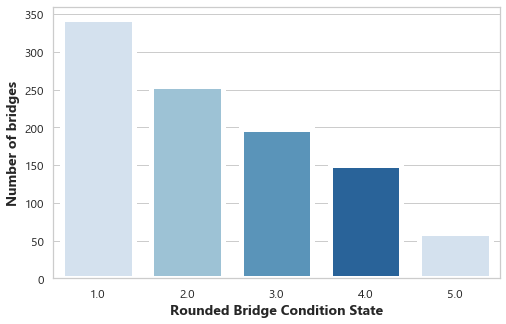

In [156]:
fig = plt.figure(figsize = (8, 5))
ax = sns.countplot(x="cond_year1", palette= sns.color_palette("Blues", 4), data=bridges, linewidth=5)
ax.set_xlabel("Rounded Bridge Condition State",fontsize=14)
ax.set_ylabel("Number of bridges",fontsize=14)
ax.tick_params(labelsize=12)
plt.show()

### 2. Maintenance intervension and impact quanitifcation (Section 2.2)

Computing the respective maintenance intervensions, the maintennace cost and improvement in condition state of the bridge based on heuristics defined in Table 1 of the paper 

In [157]:
bridges['mcost'] = 0
bridges['maintenance_description'] = 'na'
bridges['improved_cond'] = 0
for i in range(len(bridges)):
    if bridges.loc[i, 'cond_year2'] >= 2 and bridges.loc[i, 'cond_year2'] < 2.7:
        bridges.loc[i,'mcost'] = 0
        bridges.loc[i,'maintenance_description'] = 'Monitoring and Inspection '
        bridges.loc[i,'improved_cond'] = bridges.loc[i, 'cond_year2']
    elif bridges.loc[i, 'cond_year2'] >= 2.7 and bridges.loc[i, 'cond_year2'] < 3.4:
        recoating = 0.20 * bridges.loc[i, 'deck_area'] * 40
        equip_repair = 0.1 * ((bridges.loc[i, 'length'] * 630)+ (bridges.loc[i, 'width']* 3200) + 25000)
        repair = 0.10 * bridges.loc[i, 'deck_area'] * 120
        bridges.loc[i,'mcost'] = recoating + equip_repair + repair
        bridges.loc[i,'maintenance_description'] = 'Recng(20%) Equip Repr(10%) and Repr(10%)'
        bridges.loc[i,'improved_cond'] = 2
    elif bridges.loc[i, 'cond_year2'] >= 3.4 and bridges.loc[i, 'cond_year2'] < 4.1:
        recoating = 1 * bridges.loc[i, 'deck_area'] * 40
        equip_repair = 0.5 * ((bridges.loc[i, 'length'] * 630)+ (bridges.loc[i, 'width']* 3200) + 25000)
        repair = 0.20 * bridges.loc[i, 'deck_area'] * 120
        renewal = 0.10 * bridges.loc[i, 'deck_area'] * 500
        bridges.loc[i,'mcost'] = recoating + equip_repair + repair + renewal
        bridges.loc[i,'maintenance_description'] = 'Recng(100%) Equip Repr(50%), Repr(20%) and Renwl(10%)'
        bridges.loc[i,'improved_cond'] = 2
    elif bridges.loc[i, 'cond_year2'] >= 4.1:
        recoating = 1 * bridges.loc[i, 'deck_area'] * 40
        equip_repair = 1 * ((bridges.loc[i, 'length'] * 630)+ (bridges.loc[i, 'width']* 3200) + 25000)
        repair = 0.20 * bridges.loc[i, 'deck_area'] * 120
        renewal = 0.20 * bridges.loc[i, 'deck_area'] * 500
        bridges.loc[i,'mcost'] = recoating + equip_repair + repair + renewal
        bridges.loc[i,'maintenance_description'] = 'Recng(100%) Equip Repr(100%), Repr(20%) and Renwl(20%)'
        bridges.loc[i,'improved_cond'] = 1
    else:
        bridges.loc[i,'mcost'] = 0
        bridges.loc[i,'maintenance_description'] = 'Nothing'
        bridges.loc[i,'improved_cond'] = bridges['cond_year2'][i]

In [158]:
bridges.head()

,index,name,cond_year1,cond_year2,dif,length,width,auto_day,deck_area,mcost,maintenance_description,improved_cond
0,0,Bridge 1,4.0,4.0,0.0,50.0,19.0,1933.0,950.0,166950.0,"Recng(100%) Equip Repr(50%), Repr(20%) and Ren...",2.0
1,1,Bridge 2,2.0,5.0,3.0,105.0,14.0,1051.0,1470.0,377030.0,"Recng(100%) Equip Repr(100%), Repr(20%) and Re...",1.0
2,2,Bridge 3,1.0,4.0,3.0,150.0,20.0,452.0,3000.0,433750.0,"Recng(100%) Equip Repr(50%), Repr(20%) and Ren...",2.0
3,5,Bridge 6,1.0,3.0,2.0,103.0,48.0,1279.0,4944.0,123229.0,Recng(20%) Equip Repr(10%) and Repr(10%),2.0
4,7,Bridge 8,2.0,4.0,2.0,78.0,46.0,2054.0,3588.0,519702.0,"Recng(100%) Equip Repr(50%), Repr(20%) and Ren...",2.0


Since the bridges already has system-level condition index, here only user delay cost is computed. 

Calculaing the user delay cost (Equation 3 of paper)

In [159]:
#value of an hour is 9 euro
bridges['vot'] = 9 

# duration of the maintenance activity
bridges['duration'] = 0
for i in range(len(bridges)):
    if bridges.loc[i, 'maintenance_description'] == 'Recng(20%) Equip Repr(10%) and Repr(10%)':
        bridges.loc[i,'duration'] = 48
    elif bridges.loc[i,'maintenance_description'] == 'Recng(100%) Equip Repr(50%), Repr(20%) and Renwl(10%)':
        bridges.loc[i,'duration'] = 168
    elif bridges.loc[i, 'maintenance_description'] == 'Recng(100%) Equip Repr(100%), Repr(20%) and Renwl(20%)':
        bridges.loc[i,'duration'] = 312
        
#compute extra travel time
bridges['ETT'] = 0
#computing workzone as (length/1000)+1 as giel did
for i in range(len(bridges)):
    workzone_length = (bridges.loc[i, 'length'] * 0.1 )
    bridges.loc[i, 'ETT'] = (workzone_length/90) - (workzone_length/130)
    
bridges['udc'] = 0
for i in range(len(bridges)):
    bridges.loc[i,'udc'] = (bridges.loc[i, 'ETT'] * bridges.loc[i, 'auto_day'] * bridges.loc[i, 'vot'] * bridges.loc[i, 'duration'])/bridges.loc[i, 'deck_area']

#### Visulising maintenance cost and user delay cost

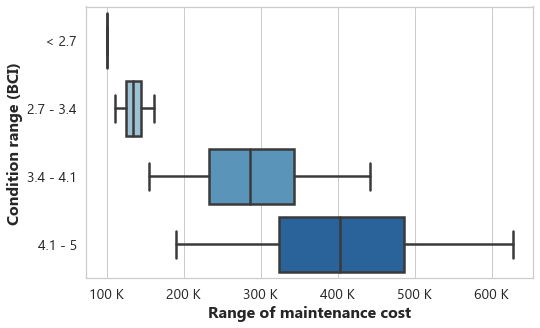

In [160]:
#bining the condition scores to create plot
bridges['cond_range'] = 0
for i in range(len(bridges)):
    if bridges['cond_year2'][i] < 2.7:
        bridges.loc[i,'cond_range'] = 1
    elif bridges['cond_year2'][i] >= np.float64(2.7) and bridges['cond_year2'][i] < np.float64(3.4):
        bridges.loc[i,'cond_range'] = 2
    elif bridges['cond_year2'][i] >= np.float64(3.4) and bridges['cond_year2'][i] < np.float64(4.1):
        bridges.loc[i,'cond_range'] = 3
    elif bridges['cond_year2'][i] >= np.float64(4.1) and bridges['cond_year2'][i] < np.float64(5):
        bridges.loc[i,'cond_range'] = 4
    elif bridges['cond_year2'][i] >= np.float64(5):
        bridges.loc[i,'cond_range'] = 5
        
#to plot maintenance cost 
fig = plt.figure(figsize = (8, 5))
color_code = ["#00FF00", "#FFFF00", "#FF8000", "#FF0000"]
ax = sns.boxplot(x="mcost", y = 'cond_range', orient = 'h', palette= sns.color_palette("Blues", 4), data=bridges, linewidth=2.5)
loc, labels = plt.xticks()
ax.set_yticklabels(['< 2.7', '2.7 - 3.4', '3.4 - 4.1', '4.1 - 5'])
ax.set_xticklabels(['0', '100 K', '200 K', '300 K', '400 K', '500 K', '600 K'])
ax.set_xlabel("Range of maintenance cost", fontsize=16 )
ax.set_ylabel("Condition range (BCI)", fontsize=16)
ax.tick_params(labelsize=14)

C:\Users\AllahBukhshZ\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\AllahBukhshZ\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 576x360 with 0 Axes>

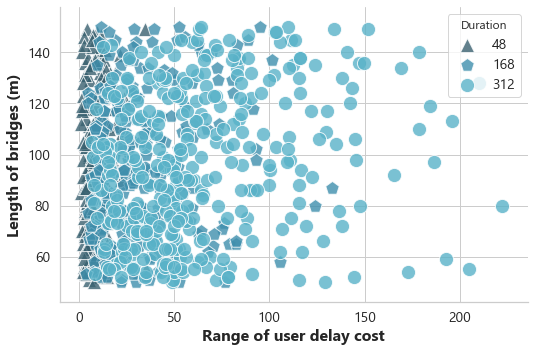

In [161]:
br_udc = bridges[bridges['udc'] != 0]
br_udc.reset_index(inplace = True)
br_udc['duration'] = br_udc['duration'].astype(int)


fig = plt.figure(figsize = (8, 5))
kws = dict(s=200, linewidth=1, edgecolor="w")
g = sns.FacetGrid(br_udc, hue = 'duration', hue_kws=dict(marker=["^", "p", 'o']), size=5, aspect=1.5, palette= sns.color_palette("GnBu_d", 4)) # Create Grid
g = (g.map(plt.scatter, "udc", "length", **kws, alpha = 0.8))
g.axes[0,0].set_xlabel("Range of user delay cost", fontsize=16)
g.axes[0,0].set_ylabel('Length of bridges (m)', fontsize=16)
loc, labels = plt.xticks()
plt.tick_params(labelsize=14)
plt.legend(title="Duration")
plt.show()

### 3. Uncertainty and perference assessment using Multi-Attribute Utility Theory (Section 2.3)

In [162]:
def plot_single_utility(original_value, utility_scores):
    #br_c = bridges.sort_values(by=['mcost_u'])
    plt.scatter(original_value, utility_scores, marker='o', s=10, color='blue')
    plt.ylabel('Utility score',  fontsize=16)
    plt.xlabel('Original data', fontsize=16)
    plt.tick_params(labelsize=14)
    loc, labels = plt.xticks()
    plt.show() # This graph shows as the cost will be high the utility will be high. which the objective as we want to prefer the minimum cost..


In [163]:
#calculating SUF of each attribute at one time! Read the paper for details 
def ComputeSUF(data, RT, CE, handle):
    utility = list()

    if handle == 1:   
        maxi = min(data)
        mini =  max(data)
    else:
        maxi = max(data)
        mini =  min(data)
    
    #calculate the expected value
    ev = 0.5*maxi + 0.5*mini
    
    #calculate the certainity equillievent of an attribute 
    #here the assumption is that the stakeholder will always have a risk avoiding attitude.
    #the CE must be lower than EV for risk avoiding attitude. So we are randomly generating value as
    # random number starting from ev/2 and end limit is ev...
    #ce = rd.uniform(ev/2, ev)
    ce = CE
    #This is the utility of certainity equillievent
    uce = math.exp(-ce/RT)
    
    a = (math.exp(-mini/RT))/(math.exp(-mini/RT)-math.exp(-maxi/RT))
    b = 1/(math.exp(-mini/RT)-math.exp(-maxi/RT))
    for i in range(len(data)):
        utility.append(a-b*math.exp(-data[i]/RT))
    
    plot_single_utility(data, utility)
    print("Maximum", maxi)
    print("Minimum",mini)
    print("EV",ev)
    print("CE",ce)
    print("U(CE)",uce)
    return utility

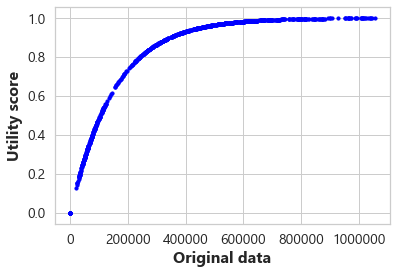

Maximum 1054306.0
Minimum 0.0
EV 527153.0
CE 250000
U(CE) 0.18887560283756183


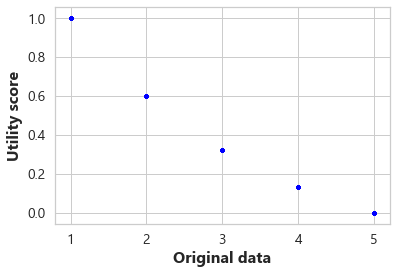

Maximum 1.0
Minimum 5.0
EV 3.0
CE 2
U(CE) 0.47676062866896984


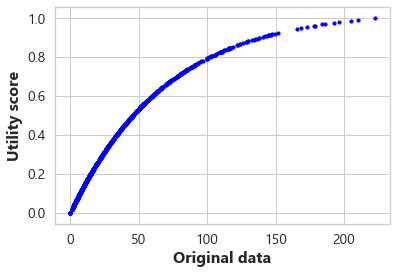

Maximum 222.28363636363636
Minimum 0.0
EV 111.14181818181818
CE 80
U(CE) 0.31890655732397044


In [164]:
bridges.reset_index(inplace = True, drop = True)
bridges['mcost_u'] = ComputeSUF(bridges['mcost'], 150000, 250000, 0) # values of RT, CE would idealy be given by stakeholder
bridges['cond_year2_u'] = ComputeSUF(bridges['cond_year2'], 2.7, 2, 1) # values of RT, CE would idealy be given by stakeholder
bridges['udc_u'] = ComputeSUF(bridges['udc'], 70, 80, 0) #values of RT, CE would idealy be given by stakeholder

In [165]:
#### calculate addititive multi-attribute utility thoery by combining the SUF and weights
#calculate the wieghts -- assign weights out of 100 to each attribute
#
cost = 80 #given by stakeholder
cond = 90 #given by stakeholder
udc = 60 #given by stakeholder
total = cost + cond+ udc
# calculate MUT
bridges['muat'] = (cost/total * bridges['mcost_u']) + (cond/total * bridges['cond_year2_u']) + (udc/total * bridges['udc_u'])
# for i in range(len(bridges)):
#     bridges.loc[i, 'muat'] = cost/total * bridges['mcost_u'][i] + cond/total * bridges['cond_year2_u'][i] + udc/total * bridges['udc_u'][i  
bridges['muat_rank'] = bridges['muat'].rank()  

### 4. Performance prediction usin Markov chain process (Section 2.4)

In [166]:
# compting transition matrix from the data. Transition matrix shows the change in condition state during inspection intervals
# IF CONDITION INDICES ARE LESS THAN 6 THAN THIS SECTION NEEDS ADJUSTMENTS!
def TransitionMatrix():
    matrix = np.matrix('0.0 0 0 0 0 0;0 0 0 0 0 0;0 0 0 0 0 0;0 0 0 0 0 0;0 0 0 0 0 0;0 0 0 0 0 0')
    
    #counting the total per condition score
    cond_values = pd.DataFrame(bridges['cond_year1'].value_counts().reset_index())
    cond_values.columns = ['cond', 'count']
    cond_values.set_index('cond', inplace = True)
    cond_1 = cond_values.loc[1].iloc[0]
    cond_2 = cond_values.loc[2].iloc[0]
    cond_3 = cond_values.loc[3].iloc[0]
    cond_4 = cond_values.loc[4].iloc[0]
    cond_5 = cond_values.loc[5].iloc[0]
    cond_6 = 1#cond_values.loc[6].iloc[0]

    # first fill up the diagonal of the matrix
    static_cond = bridges[bridges['dif'] == 0]
    matrix[0,0] = float("{0:.2f}".format(static_cond[static_cond['cond_year1'] == 1].shape[0]/ cond_1))
    matrix[1,1] = float("{0:.2f}".format(static_cond[static_cond['cond_year1'] == 2].shape[0]/cond_2))
    matrix[2,2] = float("{0:.2f}".format(static_cond[static_cond['cond_year1'] == 3].shape[0]/ cond_3))
    matrix[3,3] = float("{0:.2f}".format(static_cond[static_cond['cond_year1'] == 4].shape[0]/cond_4))
    matrix[4,4] = float("{0:.2f}".format(static_cond[static_cond['cond_year1'] == 5].shape[0]/cond_5))
    matrix[5,5] = float("{0:.2f}".format(static_cond[static_cond['cond_year1'] == 5].shape[0]/cond_5))

    
    if(cond_1 != 0):    
        #filling up CONDITION ONE
        matrix[0,1] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 1) & 
                                                                (bridges['cond_year2'] == 2)].shape[0]/cond_1))
        matrix[0,2] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 1) &
                                                                (bridges['cond_year2'] == 3)].shape[0]/cond_1))
        matrix[0,3] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 1) &
                                                                (bridges['cond_year2'] == 4)].shape[0]/cond_1))
        matrix[0,4] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 1) &
                                                                (bridges['cond_year2'] == 5)].shape[0]/cond_1))
        matrix[0,5] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 1) &
                                                                (bridges['cond_year2'] == 6)].shape[0]/cond_1))

    
    if (cond_2 != 0):      
    #filling up CONDITION TWO
        matrix[1,0] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 2) &
                                                                (bridges['cond_year2'] == 1)].shape[0]/cond_2))
        matrix[1,2] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 2) &
                                                                (bridges['cond_year2'] == 3)].shape[0]/cond_2))
        matrix[1,3] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 2) & 
                                                                (bridges['cond_year2'] == 4)].shape[0]/cond_2))
        matrix[1,4] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 2) &
                                                                (bridges['cond_year2'] == 5)].shape[0]/cond_2))
        matrix[1,5] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 2) &
                                                                (bridges['cond_year2'] == 6)].shape[0]/cond_2))

   
    if (cond_3 != 0):  
    #filling up CONDITION THREE
        matrix[2,0] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 3) &
                                                                (bridges['cond_year2'] == 1)].shape[0]/cond_3))
        matrix[2,1] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 3) &
                                                                (bridges['cond_year2'] == 2)].shape[0]/cond_3))
        matrix[2,3] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 3) &
                                                                (bridges['cond_year2'] == 4)].shape[0]/cond_3))
        matrix[2,4] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 3) &
                                                                (bridges['cond_year2'] == 5)].shape[0]/cond_3))
        matrix[2,5] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 3) &
                                                                (bridges['cond_year2'] == 6)].shape[0]/cond_3))
    
    if (cond_4 != 0):  
    #filling up CONDITION FOUR
        matrix[3,0] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 4) &
                                                                (bridges['cond_year2'] == 1)].shape[0]/cond_4))
        matrix[3,1] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 4) &
                                                                (bridges['cond_year2'] == 2)].shape[0]/cond_4))
        matrix[3,2] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 4) &
                                                                (bridges['cond_year2'] == 3)].shape[0]/cond_4))
        matrix[3,4] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 4) &
                                                                (bridges['cond_year2'] == 5)].shape[0]/cond_4))
        matrix[3,5] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 4) &
                                                                (bridges['cond_year2'] == 6)].shape[0]/cond_4))
    
    if (cond_5 != 0):  
    #filling up CONDITION FIVE
        matrix[4,0] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 5) &
                                                                (bridges['cond_year2'] == 1)].shape[0]/cond_5))
        matrix[4,1] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 5) &
                                                                (bridges['cond_year2'] == 2)].shape[0]/cond_5))
        matrix[4,2] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 5) &
                                                                (bridges['cond_year2'] == 3)].shape[0]/cond_5))
        matrix[4,3] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 5) &
                                                               (bridges['cond_year2'] == 4)].shape[0]/cond_5))
        matrix[4,5] = float("{0:.2f}".format(bridges.loc[(bridges['cond_year1'] == 5) &
                                                                (bridges['cond_year2'] == 6)].shape[0]/cond_5))
    
#     if (cond_6 != 0):  
#     #filling up CONDITION SIX
#         matrix[6,0] = float("{0:.2f}".format(weighted_bridges.loc[(weighted_bridges['cond_rnd1'] == 6) &
#                                                                 (weighted_bridges['cond_rnd2'] == 1)].shape[0]/cond_6))
#         matrix[6,1] = float("{0:.2f}".format(weighted_bridges.loc[(weighted_bridges['cond_rnd1'] == 6) & 
#                                                                 (weighted_bridges['cond_rnd2'] == 2)].shape[0]/cond_6))
#         matrix[6,2] = float("{0:.2f}".format(weighted_bridges.loc[(weighted_bridges['cond_rnd1'] == 6) &
#                                                                 (weighted_bridges['cond_rnd2'] == 3)].shape[0]/cond_6))
#         matrix[6,3] = float("{0:.2f}".format(weighted_bridges.loc[(weighted_bridges['cond_rnd1'] == 6) &
#                                                                 (weighted_bridges['cond_rnd2'] == 4)].shape[0]/cond_6))
#         matrix[6,4] = float("{0:.2f}".format(weighted_bridges.loc[(weighted_bridges['cond_rnd1'] == 6) &
#                                                                 (weighted_bridges['cond_rnd2'] == 5)].shape[0]/cond_6))
    return matrix     

In [167]:
#applying markov decision processes
trans = TransitionMatrix()
def ConvertConditionIndexToList(cond): #converting a single condition score to a row vector
    current_cond = float(cond)
    if current_cond == 1 or current_cond < 2:
        frac, whole = math.modf(current_cond)
        q = [1-frac,frac,0,0,0,0]
    elif current_cond == 2 or current_cond < 3:
        frac, whole = math.modf(current_cond)
        q = [0,1-frac,frac,0,0,0]
    elif current_cond == 3 or current_cond < 4:
        frac, whole = math.modf(current_cond)
        q = [0,0,1-frac,frac,0,0]
    elif current_cond == 4 or current_cond < 5:
        frac, whole = math.modf(current_cond)
        q = [0,0,0,1-frac,frac,0]
    elif current_cond == 5 or current_cond < 6:
        frac, whole = math.modf(current_cond)
        q = [0,0,0,0,1-frac,frac]
    elif current_cond == 6:
        q = [0,0,0,0,0,1]
    return q

def ForecastConditionPerBridgePerFiveYear(cond): #to see the change in condition state during inspection interval (5 years)
    cond_vector = ConvertConditionIndexToList(cond)
    result = np.matmul(cond_vector, trans)[0]
    print(result)
    result_updated = 1*result[0,1] + 2*result[0,1]+ 3*result[0,2]+ 4*result[0,3] + 5*result[0,4]+ 6*result[0,5]
    return result_updated

def ForecastConditionPerBridgePerYear(cond): #to see change in condition state within a year. 
    cond_vector = ConvertConditionIndexToList(cond)
    result =  np.matmul(cond_vector, trans)
    result_updated = 1*result[0,0] + 2*result[0,1]+ 3*result[0,2]+ 4*result[0,3] + 5*result[0,4]+ 6*result[0,5]
    per_year_cond = result_updated - cond
    new_per_year = cond +  (per_year_cond/5) 
    return new_per_year

In [168]:
trans

matrix([[0.22, 0.18, 0.19, 0.21, 0.2 , 0.  ],
        [0.  , 0.26, 0.27, 0.23, 0.24, 0.  ],
        [0.  , 0.  , 0.31, 0.29, 0.4 , 0.  ],
        [0.  , 0.  , 0.  , 0.49, 0.51, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [169]:
ConvertConditionIndexToList(4)

[0, 0, 0, 1.0, 0.0, 0]

In [170]:
ForecastConditionPerBridgePerFiveYear(4)

[[0.   0.   0.   0.49 0.51 0.  ]]


4.51

In [171]:
ForecastConditionPerBridgePerYear(4)

4.102

### 5. Multi-year maintenance planning using Genetic Algorithm (Section 2.5)

In [172]:
# selecting only those bridges that are in urgent need of maintenance and are within budget limit to maintain
bridges.sort_values(by=['muat'], ascending=False, inplace = True) #selecting based on multiple criteria (i.e. condition, maintenance cost and user delay cost)
bridges['mcost_cumsum'] = bridges['mcost'].cumsum()
bridges_filter = bridges[bridges['mcost_cumsum'] <= budget_limit] #selecting bridges that are within budget limit

In [173]:
#selecting data to develop most optimal maintenance plan!
bridges_filter['IsPerformed'] = False 
bridges_filter = bridges_filter[['name', 'cond_year2', 'deck_area', 'length', 'width', 'IsPerformed']]
data_arr = bridges_filter.values

C:\Users\AllahBukhshZ\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [174]:
print("No of selected bridges for scheduling ", bridges_filter.shape[0])

No of selected bridges for scheduling  10


In [175]:
#create data dictionary so GA can work
assets_set = data_arr.shape[0] #number of rows
def GetOriginalDataDic():
    data_items = {}
    for i in range(assets_set):
        data_items[i] = [data_arr[i][0], data_arr[i][1], data_arr[i][2], data_arr[i][3], data_arr[i][4], data_arr[i][5]]
    return data_items

In [176]:
#applying genetic algorithm
#maximimze condition and minimize cost (multi-objective optimization)
creator.create("FitnessMinMin", base.Fitness, weights=(-1.0, -1.0 )) #-1 because it is minimisation function of cost 
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMinMin)
toolbox = base.Toolbox()
#define the function to be applied on indiviual
toolbox.register("attr_item", rd.sample, range(assets_set), assets_set)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_item) #initlise the indiviual class
#creating population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

C:\Users\AllahBukhshZ\AppData\Local\Continuum\anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMinMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\AllahBukhshZ\AppData\Local\Continuum\anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [177]:
#fitness function
from copy import deepcopy
#fitness function
# put filters in the 

#to evaluate the quality of generated solutions
def fitnessFunction(indiv):
    individual = deepcopy(indiv)
    total_cond = 0 #minimise (to calcultate the average condition for each year)
    total_cost = 0 #minimize (total cost available)
    available_budget = budget_limit 
    list_bridge = dict() # a dictionary to get and process the bridges data
    count = 0
    cond = 0

    #Here are two stopping condition
    #if condition doesnt fulfil the condition limit criteria
    #if the cost spend become higher than the available cost
    if total_cond/len(individual) > condition_limit or total_cost > budget_limit: #stopping condition
        return 0, 100000
    #---------------------------------------------------------------------
    #list_bridge
    #lets iterate and get the data of all the bridges from data_item dict into list based on indiviual index
    org_data = GetOriginalDataDic()
    for item in individual:
        list_bridge[org_data[item][0]] = org_data[item] #(get the original data)

        
    #---------------------------------------------------------------------
    
    #Lets begin with the planning of the maintenance
    for  year in range(5):   #by default the 5 year plans will be generated (can be changed later)
        maintenance_plan = dict() # a dictionary to hold the maintenance plans
        cost_spend =  0 # cost spent in each year
        cond_avg = 0 #cond avg. per year
        x = PrettyTable(["Bridge name", "Before condition", "Maintenance treatment", "Maintenance cost", "After condition"])
        #Here again stopping condition
        if total_cond/len(individual) > condition_limit or total_cost > budget_limit: 
            return 0, 100000
            print(total_cost)
        print("Year-----------> " + str(year))
#         print(list_bridge)
        #print(list_bridge)
        for bridge in list_bridge:
            if list_bridge[bridge][1] >= 2.7: #do the maintenance of all greater than 2.7. where 6 is the worst
                if cost_spend <= budget_limit: 
                    updated_data = defineActionCost(list_bridge[bridge][1], year + 2018, list_bridge[bridge][2], list_bridge[bridge][3],list_bridge[bridge][4])#, list_bridge[bridge][3]) consider age part later on
                    action = updated_data[1] 
                    cost_spend += updated_data[2]
                    total_cost += updated_data[2]
                    maintenance_plan[list_bridge[bridge][0]] = list_bridge[bridge] + updated_data # add comment
                    list_bridge[bridge][1] = updated_data[3] #condition update
                    list_bridge[bridge][5] = True
                    #print(str(list_bridge[bridge][0]) + " " + str(list_bridge[bridge][1]))
                    #it is just to update the condition due to a maintenance activity
#                     if action == 'Do maximum': 
#                         list_bridge[bridge][1] = 1 #1 is best condition
#                     else:
#                         list_bridge[bridge][1] = list_bridge[bridge][1] - 1 #improvement in condition by 1
#                     #---------------------------------------------  
                    #rd.seed(64)
                    if cost_spend >= (available_budget/2)*rd.uniform(0,1): #to make sure only fraction of budget is spent per year
                    #if cost_spend >= available_budget/5:
                        remaining_budget = available_budget - total_cost
                        year = year + 2018
                        count = count + len(maintenance_plan)
                        for value in maintenance_plan.items():
                            x.add_row([value[1][0],float("{0:.2f}".format(value[1][1])),value[1][7],float("{0:.2f}".format(value[1][8])), float("{0:.2f}".format(value[1][9]))])
                        print(x.get_string(title=str(year)))
                        print("Summary:", "Total cost spend\t"+str(float("{0:.2f}".format(cost_spend)))+
                              "\tRemaining Budget\t"+str(remaining_budget)+
                              "\n \t No of maintained\t"+str(len(maintenance_plan))+ 
                              "\t      Average Condition\t"+str(cond/len(individual)))
                        break;
            
        # deterioate condition for a single year        
#             else:
#        
        for bridge in list_bridge:
            if list_bridge[bridge][5] == False:
                if list_bridge[bridge][1] > 4.1:
                    continue    # continue here
                list_bridge[bridge][1] = ForecastConditionPerBridgePerYear(list_bridge[bridge][1]) # the condition will deterioate by 1 over one year
                #print(str(list_bridge[bridge][0]) + " " + str(list_bridge[bridge][1]))         
    for bridge in list_bridge: 
        total_cond += list_bridge[bridge][1]  
       
    print("------------------------------------------------------------------------------")
    print("Total Cost spend", total_cost)
    print("Number of maintained bridges", count)
    print("Total Condition", total_cond)
    print("Avg Condition", total_cond/len(individual))
    print("------------------------------------------------------------------------------")
    
    return total_cond/len(individual), total_cost

In [178]:
#maintenance startgy with respect to condition
def defineActionCost(cond, year, deckarea, length, width):
    updated_data = dict()
    if cond >= 2 and cond < 2.7:
        updated_data =  [year, 'Monitoring and Inspection', 0, cond]
    if cond >= 2.7 and cond < 3.4:
        recoating = 0.20 * deckarea * 40
        equip_repair = 0.1 * ((length * 630)+ (width * 3200) + 25000)
        repair = 0.10 * deckarea * 120
        cond = cond - 0.75
        updated_data =  [year, 'Recng(20%) Equip Repr(10%) and Repr(10%)', recoating + equip_repair + repair, cond]
    elif cond >= 3.4 and cond < 4.1:
        recoating = 1 * deckarea * 40
        equip_repair = 0.5 * ((length * 630)+ (width * 3200) + 25000)
        repair = 0.20 * deckarea * 120
        renewal = 0.10 * deckarea * 500
        cond = cond - 1.5
        updated_data =  [year, 'Recng(100%) Equip Repr(50%), Repr(20%) and Renwl(10%)', 
                         recoating + equip_repair + repair + renewal, cond]
    elif cond >=4.1:
        recoating = 1 * deckarea * 40
        equip_repair = 1 * ((length * 630)+ (width * 3200) + 25000)
        repair = 0.20 * deckarea * 120
        renewal = 0.20 * deckarea * 500
        cond = cond - 2.5
        updated_data =  [year, 'Recng(100%) Equip Repr(100%), Repr(20%) and Renwl(20%)', 
                         recoating + equip_repair + repair + renewal, cond]
    else:
        updated_data =  [year, 'Do Nothing', 0, cond]
    return updated_data

In [179]:
#registering methods
toolbox.register("evaluate", fitnessFunction)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selNSGA2)

In [ ]:
population = toolbox.population(n = 500)
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
#pop = algorithms.eaSimple(population, toolbox, cxpb = 0.2, mutpb = 0.5, ngen = 100)
pop, logbook = algorithms.eaSimple(population, toolbox, cxpb = 0.2, mutpb = 0.5, ngen = 2, stats = stats,  verbose = True)

In [181]:
best_individuals = tools.selBest(population, k =20)
worst_individuals = tools.selWorst(population, k =20)

In [188]:
fitnessFunction(best_individuals[3]) #may be rexecute to find best solution!
#maximum 11 bridges can be maintained,  this is due to very poor condition state (5). 
#the original data in paper consisted of mix of broidges with varying condition states 

Year-----------> 0
+-------------+------------------+--------------------------------------------------------+------------------+-----------------+
| Bridge name | Before condition |                 Maintenance treatment                  | Maintenance cost | After condition |
+-------------+------------------+--------------------------------------------------------+------------------+-----------------+
|  Bridge 280 |       5.0        | Recng(100%) Equip Repr(100%), Repr(20%) and Renwl(20%) |     479440.0     |       2.5       |
|  Bridge 358 |       5.0        | Recng(100%) Equip Repr(100%), Repr(20%) and Renwl(20%) |     561046.0     |       2.5       |
+-------------+------------------+--------------------------------------------------------+------------------+-----------------+
Summary: Total cost spend	1040486.0	Remaining Budget	3959514.0
 	 No of maintained	2	      Average Condition	0.0
Year-----------> 1
+-------------+------------------+-----------------------------------------

(2.5, 4893256.0)

In [183]:
len(pop)

500

In [189]:
front = np.array([ind.fitness.values for ind in pop])
i = np.where(np.logical_and(np.equal(front[:,0],0),np.equal(front[:,1],100000)))
front = np.delete(front, i, axis = 1)
np.where(front == 0)
clean_front = np.delete(front, np.where(front == 0)[0] , axis = 0)
def check_plot_pareto_frontier(Xs, Ys, maxX=True, maxY=True):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
def plot_pareto_frontier(Xs, Ys, maxX=True, maxY=False):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    print(len(sorted_list))
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    
    '''Plotting process'''
    fig = plt.figure(figsize = (8, 5))
    for i in range(len(sorted_list)):
        if sorted_list[i][0] > 2.7:
            plt.scatter(sorted_list[i][0],sorted_list[i][1], s = 30,  alpha=0.8, marker = 'o', color = 'red')
        if sorted_list[i][1] > 6000000:
            plt.scatter(sorted_list[i][0],sorted_list[i][1], s = 30,  alpha=0.8, marker = 'o', color = 'red')
        if sorted_list[i][0] < 2.7 and sorted_list[i][1] < 6000000:
            plt.scatter(sorted_list[i][0],sorted_list[i][1], s = 100,  alpha=0.8, marker = '+', color = 'blue')

    plt.scatter(2.5, 4893256,  s = 100,  marker = 'D', label = 'An optimal solution')
    plt.scatter(2.6,5000000, s = 100,  alpha=0.8, marker = '+', color = 'blue', label = 'Fesible solutions')
    plt.scatter(2.8,5000000, s = 30,  alpha=0.8, marker = 'o', color = 'red', label = 'Infeasible solutions')
#     print(pareto_front)
#     pf_X = [pair[0] for pair in pareto_front]
#     pf_Y = [pair[1] for pair in pareto_front]
#     plt.plot(pf_X, pf_Y, color = 'red', linewidth = 2, linestyle = '--', label = 'Pareto frontier' )
#     plt.axhline(y=6000000, linestyle = '--', linewidth = 0.7, color = 'black')
#     plt.axvline(x=2.7, linestyle = '--', linewidth = 0.7, color = 'black')
    plt.legend()
    loc, labels = plt.yticks()
    #plt.yticks(loc, ['1M','2M','3M', '4M', '5M', '6M', '7M', '8M'])
  #  plt.yticks(loc, ['3M', '3.5M', '4M', '4.5M', '5M', '5.5M', '6M', '6.5M', '7M', '7.5M'])
    #plt.xlim(2,3)
   # plt.ylim(3500000, 7500000, 500000)
    plt.xlabel("Condition state", fontsize = 14, fontdict=dict(weight='bold'))
    plt.ylabel("Budget limit", fontsize = 14, fontdict=dict(weight='bold'))
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

500


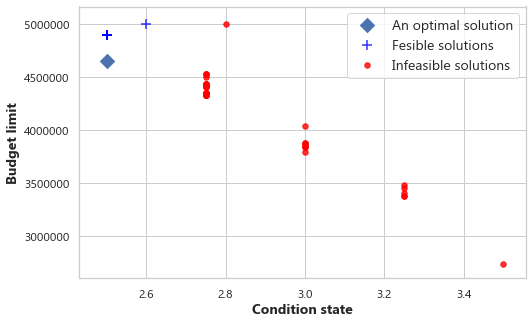

In [185]:
plot_pareto_frontier(clean_front[:,0],clean_front[:,1])

In [186]:
print("Number of fesible solutions", len(clean_front[clean_front[:,0] <2.7]))
print("Number of infesible solutions", len(clean_front[clean_front[:,0] >2.7]))

Number of fesible solutions 455
Number of infesible solutions 45
